# RL and Advanced DL: Домашнее задание 2
Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
import gym
import sys
from time import sleep
import tqdm.notebook as tq
import copy
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

DEBUG = True


## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [2]:
class NoughtsAndCrosses(gym.Env):
    N_ROWS = 3
    N_COLS = 2
    N_WINS = 3
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_wins=N_WINS):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_wins = n_wins

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.is_game_over = False
        self.board_hash = None
        # ход первого игрока
        self.cur_turn = 1
        self.empty_spaces = None
        
        self.reset()
        
    def get_num_states(self):
        return self.n_rows * self.n_cols * 3
    
    def get_total_num_actions(self):
        return self.n_rows * self.n_cols

    def get_empty_spaces(self):
        if self.empty_spaces is None:
            res = np.where(self.board == 0)
            self.empty_spaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.empty_spaces

    def make_move(self, player, i, j):
        self.board[i, j] = player
        self.empty_spaces = None
        self.board_hash = None

    def get_hash(self):
        if self.board_hash is None:
            self.board_hash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.board_hash

    def is_terminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.cur_turn), self.cur_turn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            # print((i,j))
            win = False
            if i <= self.n_rows - self.n_wins:
                if np.all(self.board[i:i+self.n_wins, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_wins:
                    if np.all(self.board[i,j:j+self.n_wins] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_wins and j <= self.n_cols - self.n_wins:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_wins) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_wins and j >= self.n_wins-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_wins) ])):
                        win = True
            if win:
                self.is_game_over = True
                return self.cur_turn

        if len(self.get_empty_spaces()) == 0:
            self.is_game_over = True
            return 0

        self.is_game_over = False
        return None

    def print_board(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def get_state(self):
        return (self.get_hash(), self.get_empty_spaces(), self.cur_turn)

    def action_from_int(self, action_int):
        return [int(action_int // self.n_cols), int(action_int % self.n_cols)]

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.get_state(), -10, True, {}
        self.make_move(self.cur_turn, action[0], action[1])
        reward = self.is_terminal()
        self.cur_turn = -self.cur_turn
        return self.get_state(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.board_hash = None
        self.is_game_over = False
        self.empty_spaces = None
        self.cur_turn = 1
        return self.get_state()
    
    def random_available_action(self):
        return random.choice(self.get_empty_spaces())
    
    def random_available_action_no(self):
        return self.int_from_action(self.random_available_action())
    
    def is_available_action(self, action):
        # print(action, self.getEmptySpaces().tolist())
        return action in self.get_empty_spaces().tolist()
    
    def is_available_action_int(self, action_no):
        return self.is_available_action(self.action_from_int(action_no))


In [3]:
def eps_greedy_strategy(env, epsilon, Q):
    """Эпсилон-жадная стратегия.
    С вероятностью эпсилон выбирает случайное действие, иначе - наиболее выгодное действие.
    
    Аргументы:
    env -- Окружение.
    epsilon -- Вероятность случайного действия.
    Q -- Выгода от действий в каждом состоянии dict: key - state, value - list values of actions.
    """
    state = env.get_state()
    state = (state[0], state[2])
    if random.random() > epsilon:
        available = [(i, v) for i, v in enumerate(Q[state]) if env.is_available_action_int(i)]
        # print(available)
        best_available = list(filter(lambda x: x[1] == max(available, key=lambda x: x[1])[1], available))
        best_action = list(env.action_from_int(random.choice(best_available)[0]))
        # print("best action", best_action)
        return best_action
    else:
        # print("random action")
        return env.random_available_action()


In [4]:
random_policy = lambda env: eps_greedy_strategy(env, 1.0, {})
best_policy = lambda env, Q: eps_greedy_strategy(env, 0.0, Q)


In [5]:
def eps_generator(eps_start=1.0, eps_min=0.01, decay=0.99999):
    """Генератор элементов убывающей геометрической прогрессии с ограничением значения минимального элемента.
    
    Аргументы:
    eps_start -- Первый элемент последовательности.
    eps_min -- Минимальное значение элементов.
    decay -- Знаменатель прогрессии.
    """
    epsilon = eps_start
    yield epsilon
    command = None
    while True:
        if command == "restart":  # Начать сначала
            epsilon = eps_start
            yield epsilon
        else:
            epsilon = max(epsilon*decay, eps_min)  # Новый член последовательности
        command = (yield epsilon)


In [6]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


In [7]:
def run_episode(env, my_policy, opponent_policy, verbose=False):
    env.reset()
    if verbose:
        env.print_board()
    done = False
    reward = 0
    
    while not done:
        action = my_policy(env)
        state, reward, done, _ = env.step(action)
        if verbose:
            env.print_board()
        if done:
            break
        action = opponent_policy(env)
        state, reward, done, _ = env.step(action)
        if verbose:
            env.print_board()
    return reward


In [8]:
def evaluate(env, my_policy, opponent_policy=random_policy, n_episodes=10000):
    reward = 0
    for i in range(n_episodes):
        reward += run_episode(env, my_policy, opponent_policy)
    return reward / n_episodes

In [12]:
def qlearning(
    env, 
    gamma=0.79, 
    learning_rate=0.002, 
    n_episodes=100,
    n_points=20,
):
    Q = defaultdict(lambda: np.zeros(env.get_total_num_actions()))
    
    quality = []
    my_policy = lambda env: eps_greedy_strategy(env, 0, Q)
    quality.append(evaluate(env, my_policy, n_episodes=n_episodes))
    
    eps_gen = eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes))
    
    for i in range(n_episodes):
        eps = next(eps_gen)
        state = env.reset()
        state = (state[0], state[2])
        
        reward_coef = 1.0
        if np.random.sample() > 0.5:
            # Other player
            action_other = eps_greedy_strategy(env, eps, Q)
            action_no_other = env.int_from_action(action_other)
            next_state_other, reward_other, done_other, _ = env.step(action_other)
            assert reward_other != -10
            state = (next_state_other[0], next_state_other[2])
            reward_coef = -reward_coef
        
        done = False
        reward = 0
        
        # While episode is not over
        while not done:
            # Choose action
            action = eps_greedy_strategy(env, eps, Q)
            action_no = env.int_from_action(action)
            # Do the action
            next_state, reward, done, _ = env.step(action)
            assert reward != -10
            reward *= reward_coef
            assert reward >= 0
            next_state = (next_state[0], next_state[2])
            if not done:
                # Other player
                action_other = eps_greedy_strategy(env, eps, Q)
                action_no_other = env.int_from_action(action_other)
                next_state_other, reward_other, done_other, _ = env.step(action_other)
                assert reward_other != -10
                reward = reward_other
                reward *= reward_coef
                assert reward <= 0
                next_state = (next_state_other[0], next_state_other[2])
                done = done_other
            # Update q_values
            td_target = reward + gamma * np.max(Q[next_state])
            td_error = td_target - Q[state][action_no]
            Q[state][action_no] += learning_rate * td_error
            # Update state
            state = next_state
        if (i + 1) % (n_episodes // n_points) == 0:
            my_policy = lambda env: eps_greedy_strategy(env, 0, Q)
            quality.append(evaluate(env, my_policy, n_episodes=n_episodes))
            print(f"{i+1}/{n_episodes}) reward={quality[-1]}, epsilon={eps}. ")
        #pbar.update(1)
        # sleep(0.001)

    plt.plot(list(range(0, n_episodes + 1, n_episodes // n_points)), quality)
    plt.ylabel("reward")
    plt.xlabel("num of iterations")
    
    best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
    return best_policy, Q


175/3500) reward=0.4062857142857143, epsilon=0.7953740702390324. 
350/3500) reward=0.38, epsilon=0.6317880811584387. 
525/3500) reward=0.46485714285714286, epsilon=0.5018471112264247. 
700/3500) reward=0.5034285714285714, epsilon=0.39863132996196693. 
875/3500) reward=0.6754285714285714, epsilon=0.31664412063448244. 
1050/3500) reward=0.7528571428571429, epsilon=0.25151936537941166. 
1225/3500) reward=0.7237142857142858, epsilon=0.19978893350080013. 
1400/3500) reward=0.75, epsilon=0.15869799086513783. 
1575/3500) reward=0.7528571428571429, epsilon=0.1260582949381955. 
1750/3500) reward=0.7517142857142857, epsilon=0.10013166289060997. 
1925/3500) reward=0.7668571428571429, epsilon=0.0795374070239053. 
2100/3500) reward=0.774, epsilon=0.06317880811584549. 
2275/3500) reward=0.7977142857142857, epsilon=0.05018471112264373. 
2450/3500) reward=0.7974285714285714, epsilon=0.03986313299619774. 
2625/3500) reward=0.8314285714285714, epsilon=0.031664412063449075. 
2800/3500) reward=0.835428571

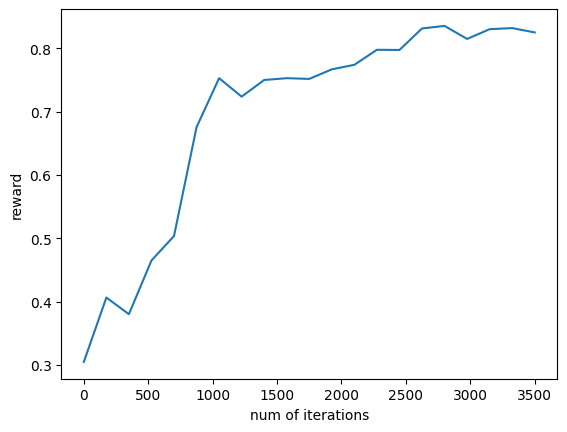

In [13]:
env = NoughtsAndCrosses(n_rows=3, n_cols=3, n_wins=3)
_ = qlearning(env, n_episodes=3500)


1000/50000) reward=0.04772, epsilon=0.9120948425269206. 
2000/50000) reward=0.04762, epsilon=0.831840382905218. 
3000/50000) reward=0.05416, epsilon=0.7586474458235686. 
4000/50000) reward=0.04982, epsilon=0.6918946938408048. 
5000/50000) reward=0.04676, epsilon=0.6310154604756849. 
6000/50000) reward=0.04908, epsilon=0.5754929397550164. 
7000/50000) reward=0.05216, epsilon=0.5248557990293995. 
8000/50000) reward=0.05206, epsilon=0.47867417781364463. 
9000/50000) reward=0.05244, epsilon=0.4365560386858438. 
10000/50000) reward=0.04996, epsilon=0.39814383926778824. 
11000/50000) reward=0.05046, epsilon=0.3631114970350185. 
12000/50000) reward=0.05068, epsilon=0.33116162119070536. 
13000/50000) reward=0.05332, epsilon=0.3020229881046151. 
14000/50000) reward=0.04802, epsilon=0.27544823888608394. 
15000/50000) reward=0.0506, epsilon=0.2512117795456175. 
16000/50000) reward=0.0516, epsilon=0.22910786591950194. 
17000/50000) reward=0.04888, epsilon=0.20894885710029704. 
18000/50000) reward=

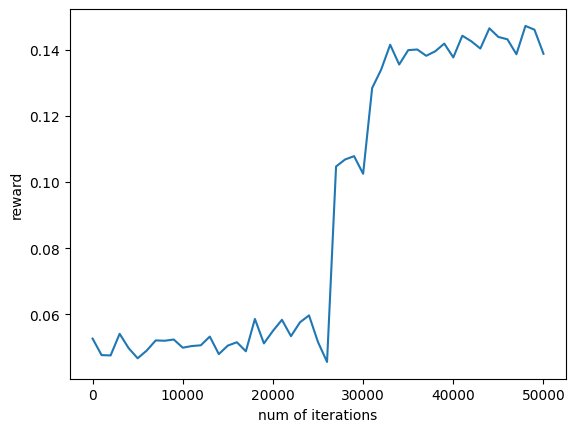

In [18]:
env = NoughtsAndCrosses(n_rows=4, n_cols=4, n_wins=4)
_ = qlearning(
    env, 
    gamma=0.79, 
    learning_rate=0.002, 
    n_episodes=50_000, 
    n_points=50
)
